In [26]:
import asyncio
from aicsimageio import imread, imread_dask
import nd2
from dask import delayed
from droplet_growth import mic, register, poisson
from glob import glob
import h5py
import tifffile as tf
import numpy as np
from napari import Viewer
import os
import pandas as pd
from threading import Thread
import re
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
big_labels = tf.imread('Y:/Lena/Data/labels_bin2+100.tif')
template16 = tf.imread('Y:/Lena/Data/20210518_control/template_bin16_bf_mask.tif')[0]
template16.shape

(818, 2612)

In [3]:
def count(path, regex='(\d+)ug', fit_poisson=True):
    cp = path.replace('.tif', '-counts.csv')
    if os.path.exists(cp):
        print(f'{path} already counted')
        return
    bf, fluo, mask = tf.imread(path)
    counts = mic.get_cell_numbers(fluo, big_labels, threshold_abs=2, plot=False, bf=bf)
    try:
        ng = re.compile(regex).findall(path)[0]
        print (int(ng), 'ug')
        counts.loc[:,'ug'] = int(ng)
    except IndexError:
        print('concentration not found')
        ng=None
    if fit_poisson:
        l = poisson.fit(counts.query('n_cells < 10').n_cells, title=f'automatic {ng}ug')
        poisson.plt.show()
        counts.loc[:, 'poisson fit'] = l
    
    counts.to_csv(cp, index=None)
    return counts

In [4]:
def align2D(path_nd2_bf_tritc, regex='(\d+)ug'):
    try:
        ng = re.compile(regex).findall(path_nd2_bf_tritc)[0]
        print (int(ng), 'ug')
    except IndexError:
        print('concentration not found')
        return
    data = imread(path_nd2_bf_tritc)[0,:,0]
    aligned, tvec = register.align_stack_nd(stack=data, path=path_nd2_bf_tritc, template16=template16, mask2=big_labels, binnings=(2,16,2))
    counts = mic.get_cell_numbers(aligned[1], aligned[2], threshold_abs=2, plot=False, bf=aligned[0])
    
    counts.loc[:,'ng'] = int(ng)
    l = poisson.fit(counts.query('n_cells < 10').n_cells, title=f'automatic {ng}ng')
    poisson.plt.show()
    counts.loc[:, 'poisson fit'] = l
    
    counts.to_csv((cp := path_nd2_bf_tritc.replace('.nd2', '-counts.csv')), index=None)
    return aligned

In [5]:
def align2D_multichip(path_nd2_bf_tritc, chip_index, concentration, unit='ug', regex='(\d+)ug'):
    try:
        ng = concentration
        print (int(ng), unit)
    except IndexError:
        print('concentration not found')
        # return
    nddata = nd2.ND2File(path_nd2_bf_tritc)
    print(nddata.sizes)
    data = np.array(nddata.to_xarray()[chip_index,:])
    print(data.shape)
    # return
    
    aligned, tvec = register.align_stack_nd(
        stack=data, 
        path=(ppp:=path_nd2_bf_tritc.replace('.nd2',f'-{concentration}{unit}.nd2')), 
        template16=template16, 
        mask2=big_labels, 
        binnings=(2,16,2)
    )
    counts = mic.get_cell_numbers(aligned[1], aligned[2], threshold_abs=2, plot=False, bf=aligned[0])
    
    counts.loc[:,unit] = int(ng)
    l = poisson.fit(counts.query('n_cells < 10').n_cells, title=f'automatic {ng}{unit}')
    poisson.plt.show()
    counts.loc[:, 'poisson fit'] = l
    
    counts.to_csv((cp := ppp.replace('.nd2', '-counts.csv')), index=None)
    return aligned

In [6]:
def align3D(path_BF, path_TRITC, path_to_save, regex='(\d+)ug'):
    try:
        ng = re.compile(regex).findall(path_BF)[0]
        print (int(ng), 'ng')
    except IndexError:
        print('concentration not found')
        return
    if not os.path.exists(path_to_save):
        BF = imread(path_BF)[0,0,0]
        fluo = imread(path_TRITC)[0,0].max(axis=0)

        aligned, tvec = register.align_stack_nd(stack=np.array((BF, fluo)), path=None, template16=template16, mask2=big_labels, binnings=(2,16,2))
        tf.imwrite(path_to_save, aligned, dtype='uint16',  imagej=True, metadata=register.META_ALIGNED)
    else:
        print('Already aligned')
        aligned = tf.imread(path_to_save)
    print('Counting ', aligned.shape)
    counts = mic.get_cell_numbers(aligned[1], aligned[2], threshold_abs=2, plot=False, bf=aligned[0])
    
    counts.loc[:,'ng'] = int(ng)
    l = poisson.fit(counts.query('n_cells < 200').n_cells, title=f'automatic {ng}ug', save_fig_path=path_to_save.replace('.tif', '-hist.png'))
    counts.loc[:, 'poisson fit'] = l
    
    counts.to_csv((cp := path_to_save.replace('.tif', '-counts.csv')), index=None)
    print(f'Saving count to {cp}')
    
    # poisson.plt.savefig((sf := path_to_save.replace('.tif', '-hist.png')))
    # print(f'Saving histogram to {sf}')
    poisson.plt.show()
    
    return aligned

In [16]:
joint_tables = glob('D:/Andrey/20220512-MIC-ecoli/00h-ampicilin-batch3-bin2/composites/?[0:8:16]ug-counts.csv')
joint_tables

['D:/Andrey/20220512-MIC-ecoli/00h-ampicilin-batch3-bin2/composites\\00ug-counts.csv',
 'D:/Andrey/20220512-MIC-ecoli/00h-ampicilin-batch3-bin2/composites\\08ug-counts.csv',
 'D:/Andrey/20220512-MIC-ecoli/00h-ampicilin-batch3-bin2/composites\\16ug-counts.csv']

In [19]:
df  = pd.concat([pd.read_csv(p, index_col=None) for p in joint_tables], ignore_index=True)

C:\Users\nikon\miniconda3\envs\nd2\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 63.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\nikon\miniconda3\envs\nd2\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\nikon\miniconda3\envs\nd2\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 68.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\nikon\miniconda3\envs\nd2\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 57.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\nikon\miniconda3\envs\nd2\lib\site-packages\seaborn\cat

Text(0.5, 1.0, 'counts 12 may 2022')

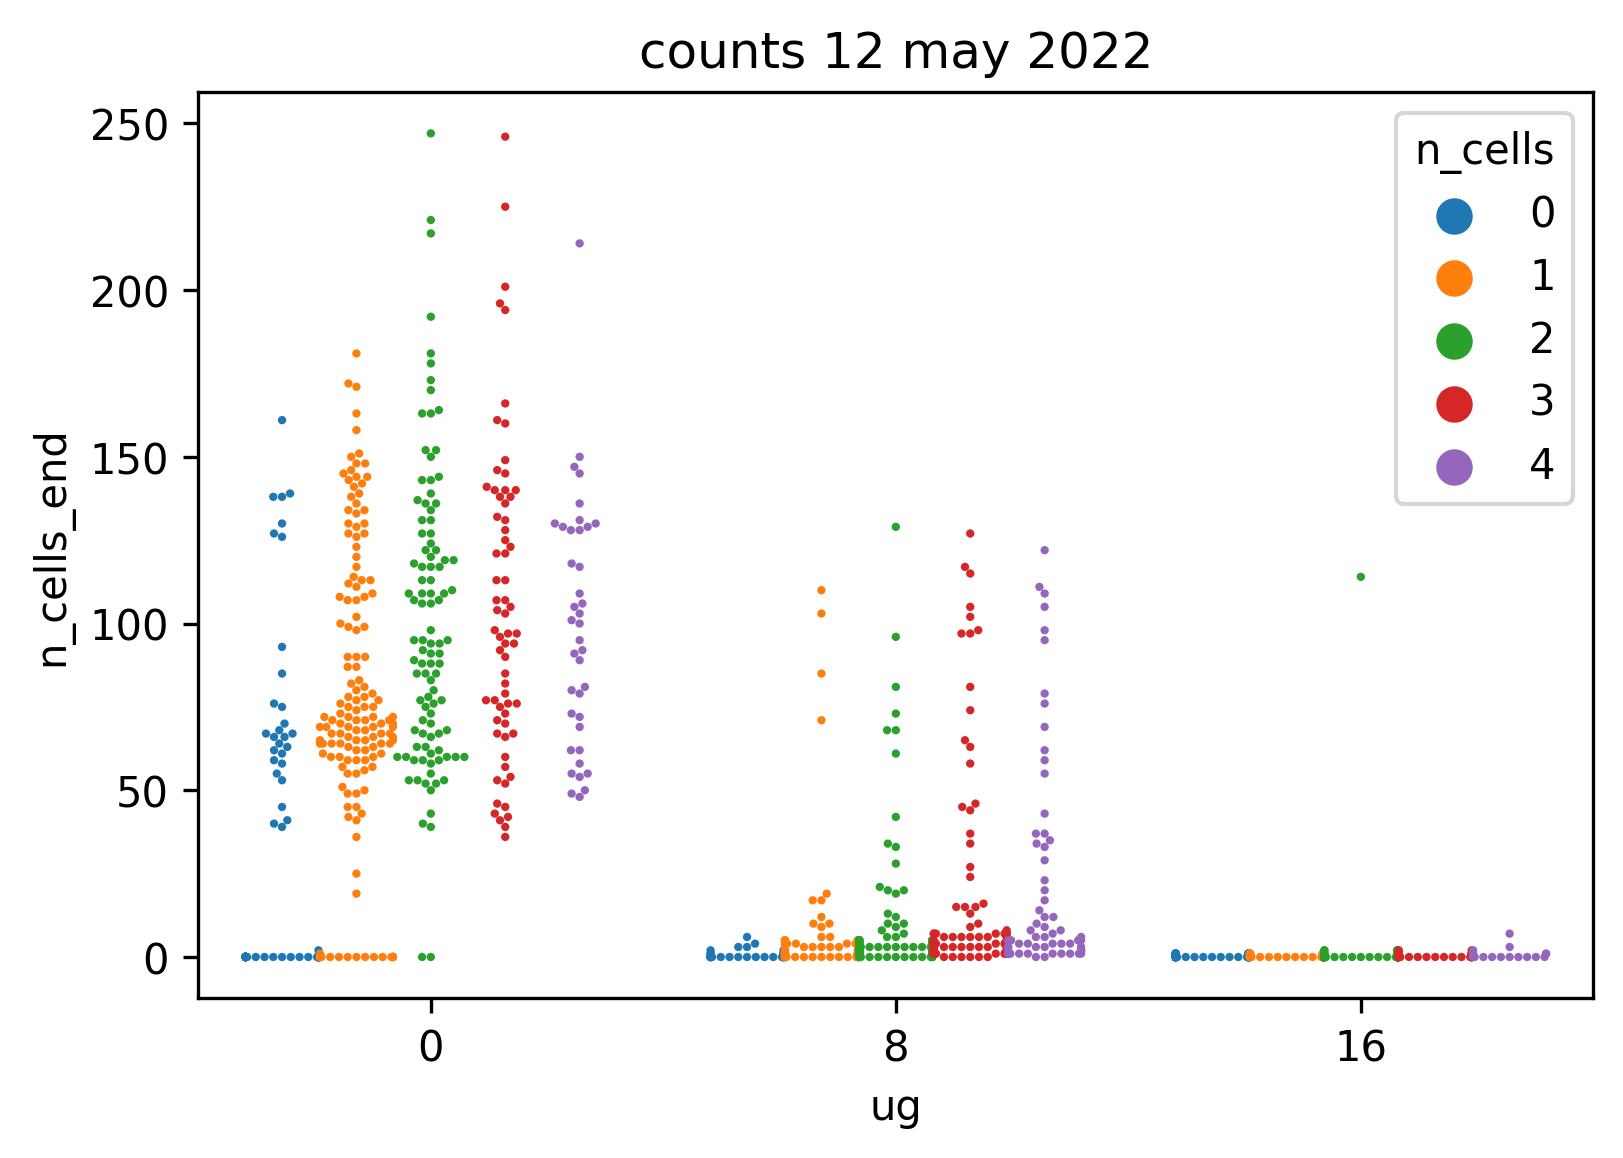

In [32]:
fig, ax = plt.subplots(dpi=300)
sns.swarmplot(data=df.query('n_cells < 5'), x='ug', y='n_cells_end', hue='n_cells', dodge=True, size=2)
ax.set_title('counts 12 may 2022')

In [29]:
df.loc[:,'positive'] = df.n_cells_end > 20

Text(0.5, 1.0, 'probs 12 may 2022')

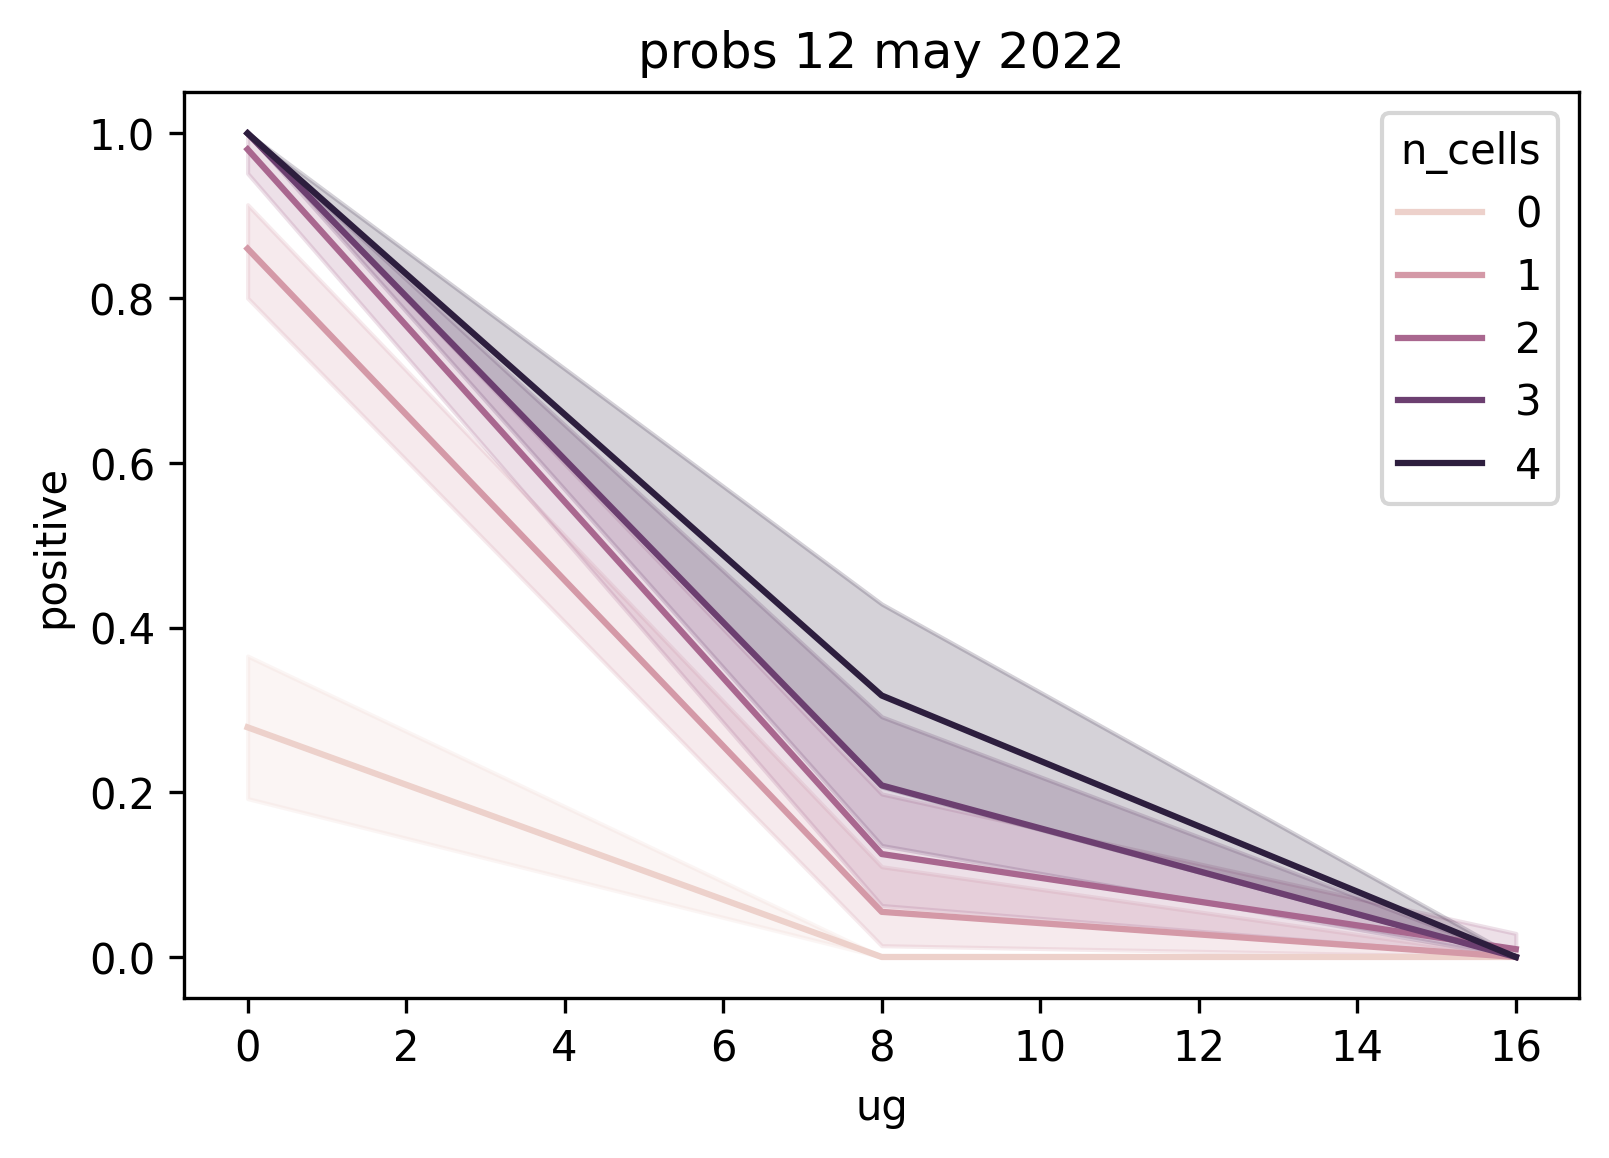

In [31]:
fig, ax = plt.subplots(dpi=300)
sns.lineplot(data=df.query('n_cells < 5'), x='ug', y='positive', hue='n_cells', )
ax.set_title('probs 12 may 2022')

In [33]:
df.to_csv('D:/Andrey/20220512-MIC-ecoli/table.csv', index=None)

## Aligning day 2

0 ug
{'P': 6, 'C': 2, 'Y': 7396, 'X': 22421}
(2, 7396, 22421)
Aligning D:/Andrey/20220512-MIC-ecoli/22h-ampicilin-batch3-bin2-6-chips/BF-TRITC-2D-0ug.nd2: 
 bf: (7396, 22421),  2
 tmp: (818, 2612),  16
 mask: (6544, 20896),  2

{'tvec': array([69.57432344, 74.97001387]), 'success': 0.08306840135403205, 'angle': -0.7370132773855005, 'scale': 0.9949757857029587, 'Dscale': 0.000474884160466049, 'Dangle': 0.013380909901873328, 'Dt': 0.25, 'timg': None}
transform (7396, 22421)
transform (7396, 22421)
Saved aligned stack D:/Andrey/20220512-MIC-ecoli/22h-ampicilin-batch3-bin2-6-chips/BF-TRITC-2D-0ug.aligned.tif


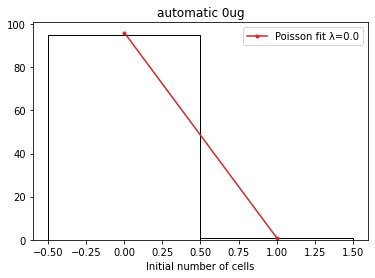

array([[[21694, 21728, 21628, ..., 21178, 21244, 21196],
        [21685, 21699, 21555, ..., 21204, 21208, 21167],
        [21660, 21687, 21612, ..., 21094, 21111, 21182],
        ...,
        [21695, 21726, 21675, ..., 21245, 21341, 21285],
        [21796, 21788, 21724, ..., 21323, 21278, 21152],
        [21823, 21760, 21737, ..., 21399, 21290, 21041]],

       [[  410,   412,   413, ...,   408,   406,   407],
        [  409,   413,   418, ...,   406,   404,   405],
        [  409,   413,   419, ...,   408,   406,   405],
        ...,
        [  414,   412,   411, ...,   413,   406,   410],
        [  415,   415,   413, ...,   415,   408,   415],
        [  412,   417,   419, ...,   414,   409,   414]],

       [[    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,    

In [8]:
align2D_multichip('D:/Andrey/20220512-MIC-ecoli/22h-ampicilin-batch3-bin2-6-chips/BF-TRITC-2D.nd2', 0, 0)

8 ug
{'P': 6, 'C': 2, 'Y': 7396, 'X': 22421}
(2, 7396, 22421)
Aligning D:/Andrey/20220512-MIC-ecoli/22h-ampicilin-batch3-bin2-6-chips/BF-TRITC-2D-8ug.nd2: 
 bf: (7396, 22421),  2
 tmp: (818, 2612),  16
 mask: (6544, 20896),  2

{'tvec': array([63.22427251, 79.31581565]), 'success': 0.06749106872137625, 'angle': -1.1407896500708432, 'scale': 0.9955420180066457, 'Dscale': 0.00047515441302498453, 'Dangle': 0.013380909901873328, 'Dt': 0.25, 'timg': None}
transform (7396, 22421)
transform (7396, 22421)
Saved aligned stack D:/Andrey/20220512-MIC-ecoli/22h-ampicilin-batch3-bin2-6-chips/BF-TRITC-2D-8ug.aligned.tif


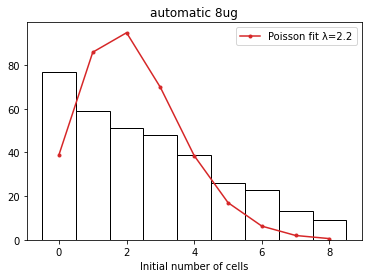

array([[[21242, 21183, 21215, ..., 20993, 20978, 21017],
        [21271, 21208, 21222, ..., 21013, 20994, 21020],
        [21382, 21311, 21199, ..., 21032, 20966, 20912],
        ...,
        [20920, 20879, 20852, ..., 20971, 20885, 20850],
        [20939, 21008, 20918, ..., 21082, 20976, 20854],
        [20807, 20851, 20852, ..., 20943, 20867, 20847]],

       [[  414,   415,   416, ...,   409,   415,   415],
        [  413,   415,   416, ...,   409,   415,   411],
        [  410,   412,   412, ...,   405,   411,   411],
        ...,
        [  411,   413,   414, ...,   415,   416,   414],
        [  411,   412,   414, ...,   416,   417,   414],
        [  411,   410,   411, ...,   415,   414,   411]],

       [[    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,    

In [9]:
align2D_multichip('D:/Andrey/20220512-MIC-ecoli/22h-ampicilin-batch3-bin2-6-chips/BF-TRITC-2D.nd2', 1, 8)

16 ug
{'P': 6, 'C': 2, 'Y': 7396, 'X': 22421}
(2, 7396, 22421)
Aligning D:/Andrey/20220512-MIC-ecoli/22h-ampicilin-batch3-bin2-6-chips/BF-TRITC-2D-16ug.nd2: 
 bf: (7396, 22421),  2
 tmp: (818, 2612),  16
 mask: (6544, 20896),  2

{'tvec': array([-0.4765171, 52.4806742]), 'success': 0.06801503516912544, 'angle': -2.8869191578934874, 'scale': 0.9943651125339524, 'Dscale': 0.0004745926970763367, 'Dangle': 0.013380909901873328, 'Dt': 0.25, 'timg': None}
transform (7396, 22421)
transform (7396, 22421)
Saved aligned stack D:/Andrey/20220512-MIC-ecoli/22h-ampicilin-batch3-bin2-6-chips/BF-TRITC-2D-16ug.aligned.tif


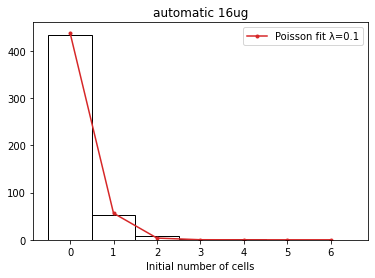

array([[[21279, 21275, 21327, ..., 21200, 21200, 21200],
        [21304, 21297, 21327, ..., 21200, 21200, 21200],
        [21322, 21303, 21316, ..., 21200, 21200, 21200],
        ...,
        [21200, 21200, 21200, ..., 21291, 21294, 21238],
        [21200, 21200, 21200, ..., 21271, 21207, 21191],
        [21200, 21200, 21200, ..., 21300, 21180, 21142]],

       [[  412,   412,   411, ...,   409,   409,   409],
        [  413,   413,   412, ...,   409,   409,   409],
        [  411,   411,   410, ...,   409,   409,   409],
        ...,
        [  409,   409,   409, ...,   408,   410,   411],
        [  409,   409,   409, ...,   407,   409,   410],
        [  409,   409,   409, ...,   407,   409,   410]],

       [[    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,    

In [10]:
align2D_multichip('D:/Andrey/20220512-MIC-ecoli/22h-ampicilin-batch3-bin2-6-chips/BF-TRITC-2D.nd2', 2, 16)

## Aligning day 1

0 ng
Aligning None: 
 bf: (6648, 22424),  2
 tmp: (818, 2612),  16
 mask: (6544, 20896),  2

{'tvec': array([113.04884173,  53.32210955]), 'success': 0.035333653855125095, 'angle': -0.5814355314121826, 'scale': 0.9955448083106556, 'Dscale': 0.00046719495495164775, 'Dangle': 0.013380909901873328, 'Dt': 0.25, 'timg': None}
transform (6648, 22424)
transform (6648, 22424)
Counting  (3, 6544, 20896)
Save histogram D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/00ug-hist.png


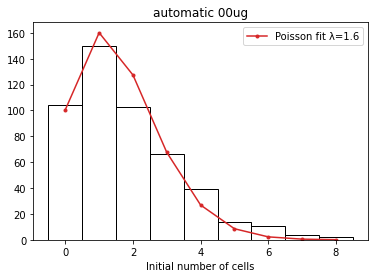

Saving count to D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/00ug-counts.csv


array([[[22497, 22602, 22608, ..., 22286, 22286, 22286],
        [22395, 22394, 22391, ..., 22286, 22286, 22286],
        [22380, 22570, 22569, ..., 22286, 22286, 22286],
        ...,
        [22558, 22596, 22654, ..., 22263, 22362, 22537],
        [22379, 22343, 22364, ..., 22568, 22577, 22619],
        [22309, 22499, 22533, ..., 22589, 22561, 22537]],

       [[  420,   421,   422, ...,   420,   420,   420],
        [  420,   422,   424, ...,   420,   420,   420],
        [  423,   420,   419, ...,   420,   420,   420],
        ...,
        [  422,   421,   419, ...,   417,   418,   421],
        [  421,   418,   416, ...,   421,   420,   418],
        [  416,   418,   419, ...,   418,   421,   419]],

       [[    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,    

In [20]:
ng=0
align3D(f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2//{ng:02d}ug-BF.nd2',
                      f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/{ng:02d}ug-TRITC.nd2',
                      f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/{ng:02d}ug.tif',)

8 ng
Aligning None: 
 bf: (6648, 22424),  2
 tmp: (818, 2612),  16
 mask: (6544, 20896),  2

{'tvec': array([-10.95531238,  49.44490118]), 'success': 0.031957999311030806, 'angle': -0.8295977233345013, 'scale': 0.9955636762805186, 'Dscale': 0.0004672038094203332, 'Dangle': 0.013380909901873328, 'Dt': 0.25, 'timg': None}
transform (6648, 22424)
transform (6648, 22424)
Counting  (3, 6544, 20896)
Save histogram D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/08ug-hist.png


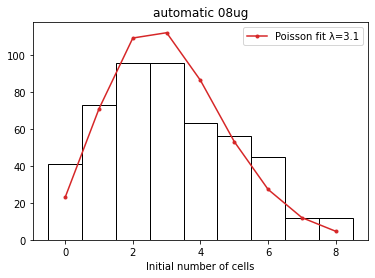

Saving count to D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/08ug-counts.csv


array([[[22252, 22295, 22216, ..., 22333, 22333, 22333],
        [22115, 22217, 22191, ..., 22333, 22333, 22333],
        [22071, 22242, 22132, ..., 22333, 22333, 22333],
        ...,
        [22333, 22333, 22333, ..., 22385, 22376, 22452],
        [22333, 22333, 22333, ..., 22474, 22453, 22524],
        [22332, 22333, 22333, ..., 22574, 22556, 22568]],

       [[  421,   424,   426, ...,   420,   420,   420],
        [  420,   423,   425, ...,   420,   420,   420],
        [  422,   427,   426, ...,   420,   420,   420],
        ...,
        [  420,   420,   420, ...,   420,   418,   420],
        [  420,   420,   420, ...,   417,   416,   418],
        [  420,   420,   420, ...,   417,   414,   415]],

       [[    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,    

In [21]:
ng=8
align3D(f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2//{ng:02d}ug-BF.nd2',
                      f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/{ng:02d}ug-TRITC.nd2',
                      f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/{ng:02d}ug.tif',)

16 ng
Aligning None: 
 bf: (7396, 22421),  2
 tmp: (818, 2612),  16
 mask: (6544, 20896),  2

{'tvec': array([111.75684441,  19.49822442]), 'success': 0.028306431150778782, 'angle': -2.6166670214557257, 'scale': 0.9944077481372637, 'Dscale': 0.0004746130462878204, 'Dangle': 0.013380909901873328, 'Dt': 0.25, 'timg': None}
transform (7396, 22421)
transform (7396, 22421)
Counting  (3, 6544, 20896)
Save histogram D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/16ug-hist.png


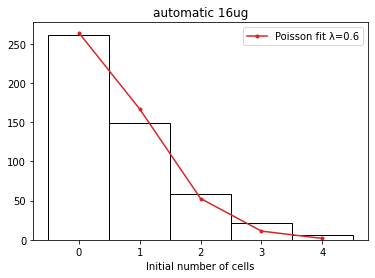

Saving count to D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/16ug-counts.csv


In [22]:
ng=16
_=align3D(f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2//{ng:02d}ug-BF.nd2',
                      f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/{ng:02d}ug-TRITC.nd2',
                      f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/{ng:02d}ug.tif',)

In [26]:
stack16_fixed = tf.imread('D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/16ug-fixed.tif')

16 ug


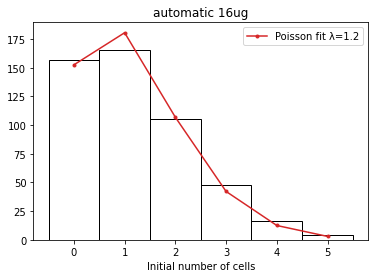

label            x             y  n_cells  ug  poisson fit
0        1   663.248626    417.128241        1  16     1.183599
1        2   664.647675    948.961450        2  16     1.183599
2        3   665.043884   1475.729516        1  16     1.183599
3        4   661.226322  16298.040220        0  16     1.183599
4        5   660.757642  16826.050217        0  16     1.183599
..     ...          ...           ...      ...  ..          ...
496    497  5962.000000   4646.000000        2  16     1.183599
497    498  5961.897296   5177.702880        2  16     1.183599
498    499  5961.526499   5706.998255        2  16     1.183599
499    500  5961.537016   6236.971642        1  16     1.183599
500    501  5961.585169   6765.801022        1  16     1.183599

[501 rows x 6 columns]

In [37]:
count('D:/Andrey/20220512-MIC-ecoli/00h-ampicilin-batch3-bin2/composites/16ug.tif')

In [38]:
count('D:/Andrey/20220512-MIC-ecoli/00h-ampicilin-batch3-bin2/composites/64ug.tif')

D:/Andrey/20220512-MIC-ecoli/00h-ampicilin-batch3-bin2/composites/64ug.tif already counted


32 ng
Aligning None: 
 bf: (6648, 22424),  2
 tmp: (818, 2612),  16
 mask: (6544, 20896),  2

{'tvec': array([-50.01357189,   5.8566224 ]), 'success': 0.036626899067913, 'angle': -0.1029520728976081, 'scale': 0.9955967804976156, 'Dscale': 0.00046721934475644887, 'Dangle': 0.013380909901873328, 'Dt': 0.25, 'timg': None}
transform (6648, 22424)
transform (6648, 22424)
Counting  (3, 6544, 20896)
Save histogram D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/32ug-hist.png


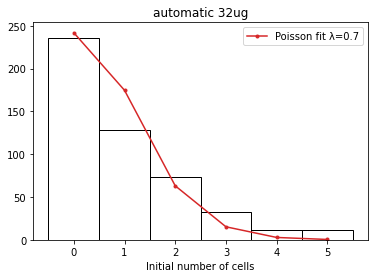

Saving count to D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/32ug-counts.csv


In [24]:
ng=32
_=align3D(f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2//{ng:02d}ug-BF.nd2',
                      f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/{ng:02d}ug-TRITC.nd2',
                      f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/{ng:02d}ug.tif',)

64 ng
Aligning None: 
 bf: (6648, 22424),  2
 tmp: (818, 2612),  16
 mask: (6544, 20896),  2

{'tvec': array([238.39210823, -39.20816774]), 'success': 0.021194287985134057, 'angle': -2.159895966281738, 'scale': 0.9963547450680954, 'Dscale': 0.0004675750467001526, 'Dangle': 0.013380909901873328, 'Dt': 0.25, 'timg': None}
transform (6648, 22424)
transform (6648, 22424)
Counting  (3, 6544, 20896)
Save histogram D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/64ug-hist.png


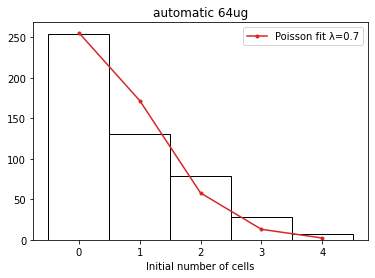

Saving count to D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/64ug-counts.csv


In [25]:
ng=64
_=align3D(f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2//{ng:02d}ug-BF.nd2',
                      f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/{ng:02d}ug-TRITC.nd2',
                      f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/{ng:02d}ug.tif',)

128 ng
Aligning None: 
 bf: (6648, 22424),  2
 tmp: (818, 2612),  16
 mask: (6544, 20896),  2

{'tvec': array([175.74905564,  47.28177099]), 'success': 0.03627910747774752, 'angle': 0.7315252047362435, 'scale': 0.9949675970461134, 'Dscale': 0.0004669240779519545, 'Dangle': 0.013380909901873328, 'Dt': 0.25, 'timg': None}
transform (6648, 22424)
transform (6648, 22424)
Counting  (3, 6544, 20896)
Save histogram D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/128ug-hist.png


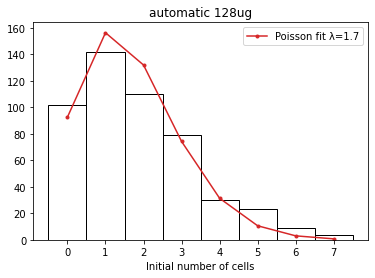

Saving count to D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/128ug-counts.csv


In [28]:
ng=128
_=align3D(f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2//{ng:02d}ug-BF.nd2',
                      f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/{ng:02d}ug-TRITC.nd2',
                      f'D:/Andrey/20220512-MIC-e.coli/00h-ampicilin-batch3-bin2/composites/{ng:02d}ug.tif',)

In [ ]:
ng=0
Thread(target=align3D, args=(f'E:/Andrey/20220127-W3110_WT_RFP+/day1/{ng:03d}ng-BF.nd2',
                      f'E:/Andrey/20220127-W3110_WT_RFP+/day1/{ng:03d}ng-TRITC.nd2',
                      f'E:/Andrey/20220127-W3110_WT_RFP+/day1/{ng:03d}ng.tif',)).start()

In [ ]:
ng=0
Thread(target=align3D, args=(f'E:/Andrey/20220127-W3110_WT_RFP+/day1/000ng-BF_after4h.nd2',
                      f'E:/Andrey/20220127-W3110_WT_RFP+/day1/000ng-TRITC_after4h.nd2',
                      f'E:/Andrey/20220127-W3110_WT_RFP+/day1/000ng_after4h.tif',)).start()

In [ ]:
ng=0
Thread(target=align3D, args=(f'E:/Andrey/20220127-W3110_WT_RFP+/day1/000ng-BF.nd2',
                      f'E:/Andrey/20220127-W3110_WT_RFP+/day1/000ng-TRITC.nd2',
                      f'E:/Andrey/20220127-W3110_WT_RFP+/day1/000ng.tif',)).start()

In [ ]:
ng=256
Thread(target=align3D, args=(f'E:/Andrey/20220127-W3110_ciproR_RFP+//day1/{ng:03d}ng-BF.nd2',
                      f'E:/Andrey/20220127-W3110_ciproR_RFP+/day1/{ng:03d}ng-TRITC.nd2',
                      f'E:/Andrey/20220127-W3110_ciproR_RFP+/day1/{ng:03d}ng.tif',)).start()

In [ ]:
from aicsimageio import imread_xarray_dask

In [ ]:
img = imread_xarray_dask('E:/Andrey/20220124-MIC-cipro-resistant//day1/raw/{ng:03d}ng-BF001.nd2')

In [ ]:
paths = glob('E:Andrey/20220125-test-novec/*/*ng*.nd2')
paths

In [ ]:
Thread(target=align3D, args=('E:Andrey/20220125-test-novec\\10min\\0ng-BF.nd2',
                             'E:Andrey/20220125-test-novec\\10min\\0ng-TRITC.nd2',
                             'E:Andrey/20220125-test-novec\\10min\\0ng-composite.tif',)).start()

In [ ]:
Thread(target=align3D, args=('E:Andrey/20220125-test-novec\\24h\\0ng-BF.nd2',
                             'E:Andrey/20220125-test-novec\\24h\\0ng-TRITC.nd2',
                             'E:Andrey/20220125-test-novec\\24h\\0ng-composite.tif',)).start()

In [ ]:
Thread(target=align2D, args=("E:Andrey/20220124-MIC-cipro-resistant//day2/raw\\000ng-BF-TRITC-cf-wf.nd2",)).start()

In [ ]:
_ = [Thread(target=align2D, args=(p,)).start() for p in paths]

In [ ]:
_

In [ ]:
h5fn = '/home/aaristov/Anchor/Lena/Data/20220118-MIC-cipro-resistant/20220118-MIC-cipro-resistant.h5'

In [ ]:
with h5py.File(h5fn,'w') as f:
    f.create_dataset('mask', data=big_labels, dtype='uint16')

In [ ]:
glob('/home/aaristov//Anchor/Lena/Data/20220118-MIC-cipro-resistant/day2/composites/*ng-BF-TRITC.aligned.tif')

In [ ]:
with h5py.File(h5fn,'a') as f:
    try:
        d1 = f.create_group('day2')
    except ValueError:
        d1 = f['day2']
    for p in glob('/home/aaristov//Anchor/Lena/Data/20220118-MIC-cipro-resistant/day2/composites/*ng-BF-TRITC.aligned.tif'):
        ng = re.compile('(\d+ng)').findall(p)[0]
        print(ng)
        bf, fluo, _ = tf.imread(p)
        try:
            c = d1.create_group(ng)
        except ValueError:
            c = d1[ng]
        c.create_dataset('bf', data=bf, dtype=bf.dtype)
        c.create_dataset('fluo', data=fluo, dtype=fluo.dtype)
        
    

In [ ]:
with h5py.File('F:/Andrey/20220118-MIC-cipro-resistant.h5','a') as f:
    d1 = f.create_group('day1')
    for p in glob('/home/aaristov/Anchor/Lena/Data/20220118-MIC-cipro-resistant/day1/composites/*ng.tif'):
        ng = re.compile('(\d+ng)').findall(p)[0]
        print(ng)
        bf, fluo, _ = tf.imread(p)
        c = d1.create_group(ng)
        c.create_dataset('bf', data=bf, dtype=bf.dtype)
        c.create_dataset('fluo', data=fluo, dtype=fluo.dtype)
        
    

In [ ]:
for p in glob('/home/aaristov/Anchor/Lena/Data//20220118-MIC-cipro-resistant/day2/composites/*ng-BF-TRITC-counts.csv'):
    ng = re.compile('(\d+ng)').findall(p)[0]
    print(ng)
    pd.read_csv(p).to_hdf(h5fn, f'day2/{ng}/counts', 'a',)

In [ ]:
for p in glob('/home/aaristov/Anchor/Lena/Data//20220118-MIC-cipro-resistant/day1/composites/*counts.csv'):
    ng = re.compile('(\d+ng)').findall(p)[0]
    print(ng)
    pd.read_csv(p).to_hdf(h5fn, f'day1/{ng}/counts', 'a',)

In [ ]:
pd.read_hdf(h5fn, 'day1/032ng/counts',)

In [ ]:
with h5py.File('/home/aaristov/Anchor/Lena/Data/20220118-MIC-cipro-resistant//20220118-MIC-cipro-resistant.h5','r') as f:
    print(f['day2/032ng'].keys())
    

In [ ]:
with h5py.File('F:/Andrey/20220118-MIC-cipro-resistant.h5','w') as f:
    f['day1'].name = 'day2'
    

In [ ]:
img = imread('E:/Andrey/20220111-MIC-resistant/000ng-TRITC.nd2')
img.shape

In [ ]:
proj = img[0,0].max(axis=0)

In [ ]:
proj.shape

In [ ]:
t = asyncio.create_task(align3D(path_BF='E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/020ug-BF.nd2', 
                                path_TRITC='E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/020ug-TRITC.nd2',
                                path_to_save='E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/composites/020ug.tif'))

In [ ]:
imread(r'E:Andrey/20220113-MIC-W8110_RFPplus-amp/day1/020ug-BF.nd2')

In [ ]:
_ = await asyncio.gather(t)

In [ ]:
_

In [ ]:
Thread(target=align3D, args=('E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/004ug-BF.nd2', 
                               'E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/004ug-TRITC.nd2',
                                'E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/composites/004ug.tif')).start()

In [ ]:
Thread(target=align3D, args=('E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/008ug-BF.nd2', 
                               'E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/008ug-TRITC.nd2',
                                'E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/composites/008ug.tif')).start()

In [ ]:
Thread(target=align3D, args=('E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/012ug-BF.nd2', 
                               'E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/012ug-TRITC.nd2',
                                'E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/composites/012ug.tif')).start()

In [ ]:
Thread(target=align3D, args=('E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/002ug-BF.nd2', 
                               'E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/002ug-TRITC.nd2',
                                'E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/composites/002ug.tif')).start()

In [ ]:
Thread(target=align3D, args=('E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/032ug-BF.nd2', 
                               'E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/032ug-TRITC.nd2',
                                'E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/composites/032ug.tif')).start()

In [ ]:
Thread(target=align3D, args=('E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/016ug-BF.nd2', 
                               'E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/016ug-TRITC.nd2',
                                'E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/composites/016ug.tif')).start()

In [ ]:
Thread(target=align3D, args=('E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/064ug-BF.nd2', 
                               'E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/064ug-TRITC.nd2',
                                'E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/composites/064ug.tif')).start()

In [ ]:
for p in glob('E:/Andrey/20220113-MIC-W8110_RFPplus-amp/day1/composites/*ug.tif'):
    Thread(target=count, args=(p,)).start()

In [ ]:
for p in glob('Y:Lena/Data/20220111-MIC-resistant/composites-0h/*ng-Composite..aligned.tif'):
    threading.Thread(target=count, args=(p, '(\d+)ng')).start() 

In [ ]:
for p in glob('Y:Lena/Data/20220111-MIC-resistant/composites-0h/*ng-Composite.tif'):
    threading.Thread(target=register.align_stack, kwargs=dict(data_or_path=p, template16=template16, mask2=big_labels, binnings=(2,16,2))).start() 

In [ ]:
for p in glob('Y:Lena/Data/20220111-MIC-resistant/composites-0h/*ng-Composite.aligned.tif'):
    threading.Thread(target=count, args=(p, '(\d+)ng')).start() 

In [ ]:
img = imread('Y:Lena/Data/20220111-MIC-resistant/day2/032ng-BF-TRIRC-2D.nd2')
img.shape

In [ ]:
for p in glob('Y:Lena/Data/20220111-MIC-resistant/day2/*ng-BF-TRIRC-2D.nd2'):
    threading.Thread(target=align2D, args=(p,)).start() 

In [ ]:
threading.Thread(target=align2D, args=('Y:Lena/Data/20220111-MIC-resistant/day2/128ng-BF-TRIRC-2D.nd2',)).start()

In [ ]:
for p in glob('Y:/Lena/Data//20220111-MIC-resistant/day2/*ng-BF-TRIRC-2D.aligned.tif'):
    threading.Thread(target=count, args=(p, '(\d+)ng')).start()

In [ ]:
timelapse = imread_dask('Y:Lena/Data//20220111-MIC-resistant/timelapse-30min/0ng-TRITC-19h.nd2')

In [ ]:
timelapse = timelapse.rechunk((1,1,1,1000,1000))

In [ ]:
timelapse

In [ ]:
max_proj = timelapse.max(axis=2).compute()

In [ ]:
max_proj.shape

In [ ]:
mean_proj = timelapse.mean(axis=2, dtype='float32').compute()

In [ ]:
tf.imwrite('E:Andrey/20220111-MIC-resistant/timelapse-30min/0ng-TRITC-19h_maxIP.tif', max_proj)

In [ ]:
tf.imwrite('Y:Lena/Data//20220111-MIC-resistant/timelapse-30min/0ng-TRITC-19h_meanIP.tif', mean_proj)

In [ ]:
mean_proj = tf.imread('Y:Lena/Data//20220111-MIC-resistant/timelapse-30min/0ng-TRITC-19h_meanIP.tif')

In [ ]:
import napari

In [ ]:
v = napari.Viewer()

In [ ]:
# fluo = tf.imread('E:Andrey/20220111-MIC-resistant/timelapse-30min/0ng-TRITC-19h_maxIP.tif')
bf = imread('Y:Lena/Data/20220111-MIC-resistant/timelapse-30min/0ng-BF.nd2')
bf.shape

In [ ]:
mean_proj.shape

In [ ]:
aligned_maxIP = register.align_timelapse(bf[0,0,0], fluo[:,0], template16=template16, mask2=big_labels, binnings=(2,16,2))

In [ ]:
aligned_meanIP = register.align_timelapse(bf[0,0,0], mean_proj[:,0], template16=template16, mask2=big_labels, binnings=(2,16,2))

In [ ]:
tf.imwrite('Y:Lena/Data/20220111-MIC-resistant/timelapse-30min/0ng-fluo-aligned-end.tif', aligned_meanIP[1][38])

In [ ]:
fluo = np.array(aligned_meanIP[1]).reshape((39, 1, 1, 6544, 20896))

In [ ]:
fluo.shape

In [ ]:
fluo[:,:,:,:10,:10].shape

In [ ]:
tf.imwrite('Y:Lena/Data/20220111-MIC-resistant/timelapse-30min/0ng-fluo-aligned-bin10.tif', fluo[:,:,:,::10,::10])

In [ ]:
from droplet_growth import multiwell

In [ ]:
labels = tf.imread('Y:/Lena/Data/20220111-MIC-resistant/timelapse-30min/lables.tif')

In [ ]:
labels

In [ ]:
labels.shape

In [ ]:
fluo[:,0,0].shape

In [ ]:
intensities = multiwell.get_intensity_table(labelled_mask=labels.astype('int'), intensity_image_sequence=fluo[:,0,0])intensities = multiwell.get_intensity_table(labelled_mask=labels.astype('int'), intensity_image_sequence=fluo[:,0,0])

In [ ]:
intensities.loc[:, 'h'] = intensities.time * .5

In [ ]:
intensities.to_csv("Y:Lena/Data/20220111-MIC-resistant/timelapse-30min/intesities.csv", index=None)

In [ ]:
import seaborn as sns

In [ ]:
sns.lineplot(data=intensities, x='h', y='I', hue='label', estimator=None, units='label')

In [ ]:
v.add_image(fluo, contrast_limits=(400,600))

In [ ]:
np.array(aligned_maxIP[1]).shape

In [ ]:
tf.imwrite('Y:Lena/Data/20220111-MIC-resistant//timelapse-30min/0ng-TRITC-19h_maxIP.aligned.tif', fluo)

In [ ]:
tf.imwrite('Y:Lena/Data/20220111-MIC-resistant//timelapse-30min/0ng-TRITC-19h_meanIP.aligned.tif', fluo)

In [ ]:
tf.imwrite('E:Andrey/20220111-MIC-resistant/timelapse-30min/0ng-BF.aligned.tif', aligned_maxIP[0])

In [ ]:
tf.imwrite('E:Andrey/20220111-MIC-resistant/timelapse-30min/lables.tif', aligned_maxIP[2])

In [ ]:
for p in glob('E:Andrey/20220113-MIC-W8110_RFPplus-amp/day2/*.nd2'):
    _= Thread(target=align2D, args=(p,)).start()

In [ ]:
for p in glob('E:Andrey/20220113-MIC-W8110_RFPplus-amp/day2/*.tif'):
    print(''.join(p.split('.')[:-1]) + '-counts.csv')
    _= Thread(target=count, args=(p,)).start()

In [ ]:
tvec  = register.get_transform(bf[0,0,0,::8,::8], template16, plot=False)

In [ ]:
tvec

In [ ]:
tvec_scaled = register.scale_tvec(tvec, 8)

In [ ]:
tvec_scaled

In [ ]:
from scipy.ndimage.interpolation import zoom, rotate, shift

In [ ]:
fluo = fluo.reshape((39, 1, 1, 7383, 22392))
fluo.shape

In [ ]:
rfluo = rotate(input=fluo, angle=tvec_scaled['angle'], axes=(4,3))

In [ ]:
del fluo

In [ ]:
z = tvec_scaled['scale']
zfluo = zoom(input=fluo, zoom=(1,1,1,z,z),)

In [ ]:
rfluo.shape

In [ ]:
v.add_image(rfluo, contrast_limits=(440,600))